In [114]:
import torch
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from omegaconf import OmegaConf

from nlp.datasets.datamodule import Datamodule
from nlp.lightning_model.flow_augmentation_model import FlowAugmentationModel

In [115]:
sns.set_theme(style='darkgrid')

# Load the dataset

In [116]:
datamodule_config = OmegaConf.load('/home/konradkaranowski/nlp-classes/source/nlp/config/datamodule/herbert.yaml')

In [4]:
datamodule = Datamodule(**datamodule_config)
datamodule.prepare_data()
datamodule.setup('test')
dataset = datamodule.train_dataloader().dataset

2024-01-09 22:25:44 - INFO - Loaded the data from /home/konradkaranowski/storage/nlp/herbet_df.csv


# Load the models

In [39]:
DEVICE = torch.device('cuda')

In [40]:
NICE_PATH = '/home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_augmentation/runs/2024-01-09_20-33-26/checkpoints/epoch_001.ckpt'
MAF_PATH = '/home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_augmentation/runs/2024-01-09_20-33-48/checkpoints/epoch_001.ckpt'
REAL_NVP_PATH = '/home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_augmentation/runs/2024-01-09_20-34-01/checkpoints/epoch_007.ckpt'

In [41]:
nice_flow = FlowAugmentationModel.load_from_checkpoint(NICE_PATH)
nice_flow.eval()
nice_flow.to(DEVICE)
pass

2024-01-09 22:27:18 - DEBUG - open file: /home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_augmentation/runs/2024-01-09_20-33-26/checkpoints/epoch_001.ckpt


In [42]:
maf_flow = FlowAugmentationModel.load_from_checkpoint(MAF_PATH)
maf_flow.eval()
maf_flow.to(DEVICE)
pass

2024-01-09 22:27:19 - DEBUG - open file: /home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_augmentation/runs/2024-01-09_20-33-48/checkpoints/epoch_001.ckpt


In [43]:
rnvp_flow = FlowAugmentationModel.load_from_checkpoint(REAL_NVP_PATH)
rnvp_flow.eval()
rnvp_flow.to(DEVICE)
pass

2024-01-09 22:27:20 - DEBUG - open file: /home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_augmentation/runs/2024-01-09_20-34-01/checkpoints/epoch_007.ckpt


# Helpers

In [16]:
from sklearn.decomposition import PCA

In [25]:
def transform(model, x, y):
    y = torch.nn.functional.one_hot(torch.from_numpy(y), 12).float()
    with torch.no_grad():
        return model.flow.transform_to_noise(x.cuda(), context=y.cuda()).cpu()

In [26]:
def get_random_samples(dataset: int, n: int):
    indexes = list(range(len(dataset)))
    choices = np.random.choice(indexes, size=n)
    return [dataset[i] for i in choices], choices

In [27]:
def get_pca(x, n_components: int = 2):
    pca = PCA(n_components=2)
    return pca.fit_transform(x)

# Show latent space

In [108]:
NUM_RANDOM_SAMPLES = 8

In [109]:
random_samples, _ = get_random_samples(dataset, NUM_RANDOM_SAMPLES)

In [110]:
real_xs = torch.stack([r['x'] for r in random_samples])
y = np.array([r['y'] for r in random_samples])

In [111]:
maf_xs = transform(maf_flow, real_xs, y)
nice_xs = transform(nice_flow, real_xs, y)
rnvp_xs = transform(rnvp_flow, real_xs, y)

In [112]:
real_pca = get_pca(real_xs.numpy(), n_components=2)
maf_pca = get_pca(maf_xs.numpy(), n_components=2)
nice_pca = get_pca(nice_xs.numpy(), n_components=2)
rnvp_pca = get_pca(rnvp_xs.numpy(), n_components=2)

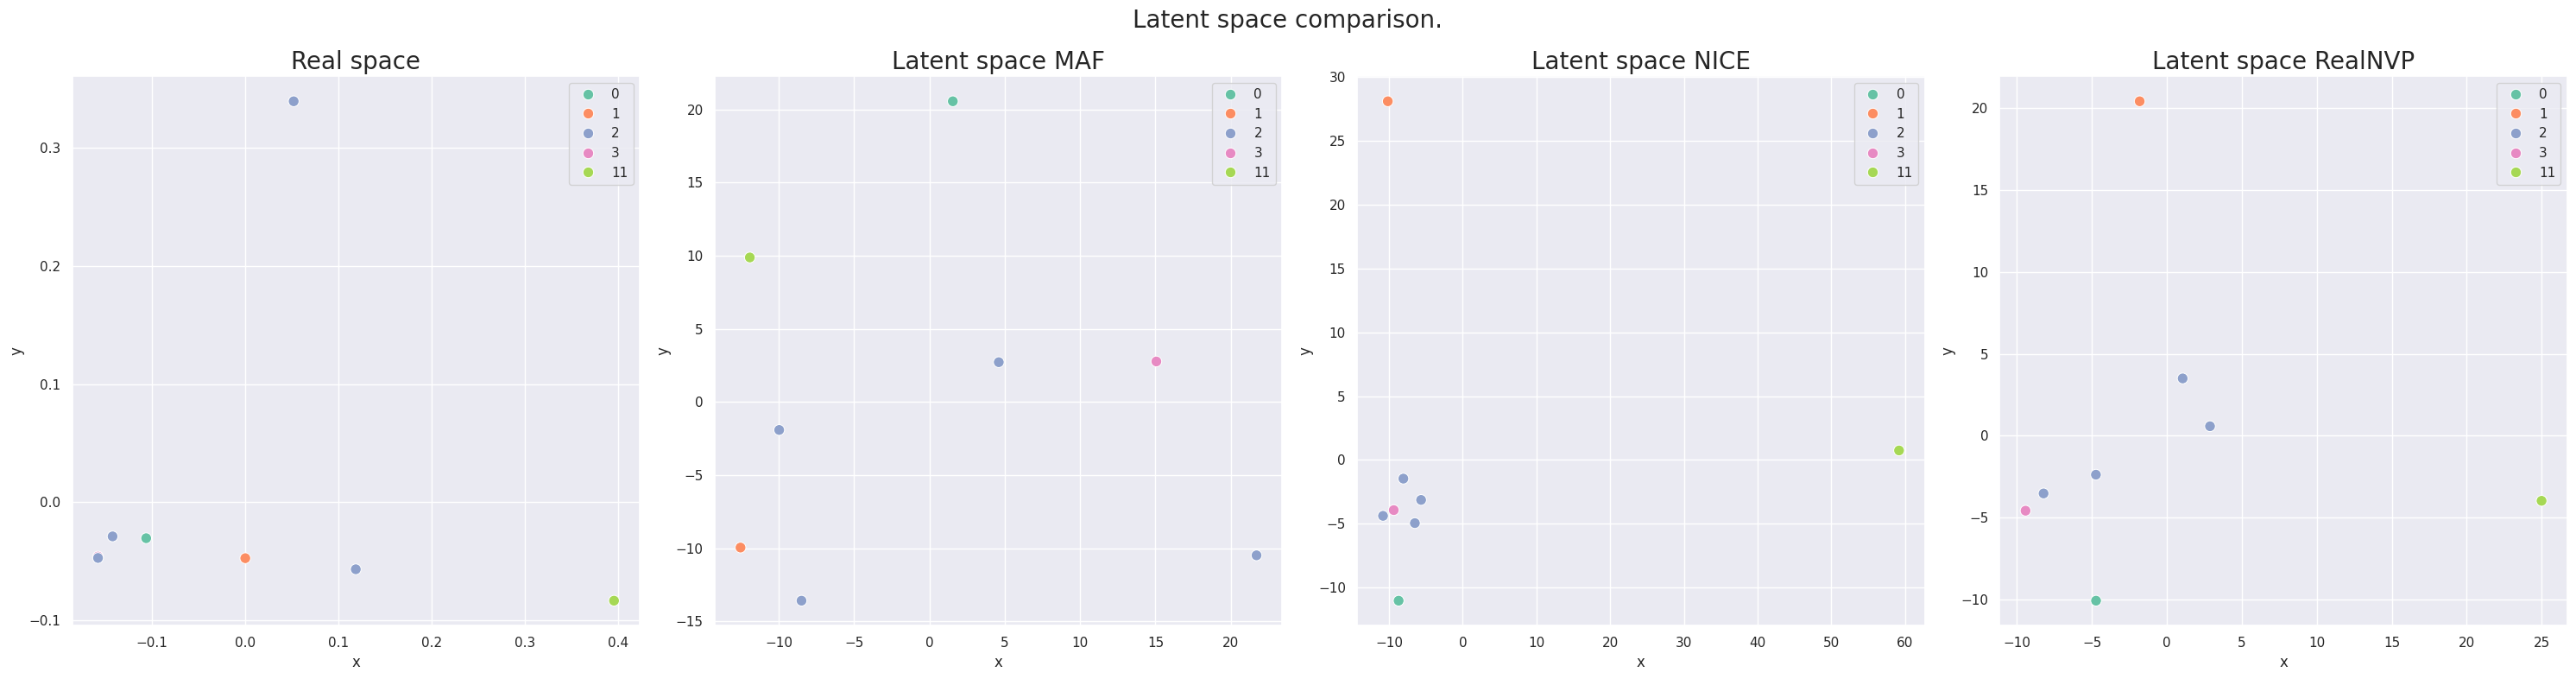

In [122]:
fig, ax = plt.subplots(1, 4, figsize=(30, 8))

sns.scatterplot(x=real_pca[:, 0], y=real_pca[:, 1], ax=ax[0], hue=y, palette='Set2', s=80)
ax[0].set_title('Real space', fontdict={'fontsize': 20})


sns.scatterplot(x=maf_pca[:, 0], y=maf_pca[:, 1], ax=ax[1], hue=y, palette='Set2', s=80)
ax[1].set_title('Latent space MAF', fontdict={'fontsize': 20})

sns.scatterplot(x=nice_pca[:, 0], y=nice_pca[:, 1], ax=ax[2], hue=y, palette='Set2', s=80)
ax[2].set_title('Latent space NICE', fontdict={'fontsize': 20})

sns.scatterplot(x=rnvp_pca[:, 0], y=rnvp_pca[:, 1], ax=ax[3], hue=y, palette='Set2', s=80)
ax[3].set_title('Latent space RealNVP', fontdict={'fontsize': 20})



for a in ax:
    a.set_xlabel('x')
    a.set_ylabel('y')
    
fig.suptitle('Latent space comparison.', size=20)
fig.tight_layout()
plt.savefig('plots/comparison.png')
plt.show()

# Show perturbations

In [63]:
ALPHAS = [0.0001, 0.001, 0.01, 0.1]

In [78]:
def perturbate(model, x, y, alpha, n):
    Z = transform(model, x, y)
    torch.cuda.empty_cache()
    xs = []
    ys = []
    for y_, z in zip(y, Z):
        
        z_hat = alpha * torch.randn(n, z.shape[0]) + z
        with torch.no_grad():
            x_inv, _ = model.flow._transform.inverse(z_hat.cuda(), context=torch.nn.functional.one_hot(torch.tensor([y_] * n), 12).float().cuda())
        xs.append(x_inv.cpu())
        ys.extend([y_] * n)
    return torch.cat(xs, dim=0), ys, Z

In [79]:
torch.cuda.empty_cache()

In [80]:
results_maf = []
for alpha in ALPHAS:
    print(alpha)
    maf_xs, maf_ys, maf_z = perturbate(maf_flow, real_xs, y, alpha, 5)
    results_maf.append((maf_xs, maf_ys, maf_z))

0.0001
0.001
0.01
0.1


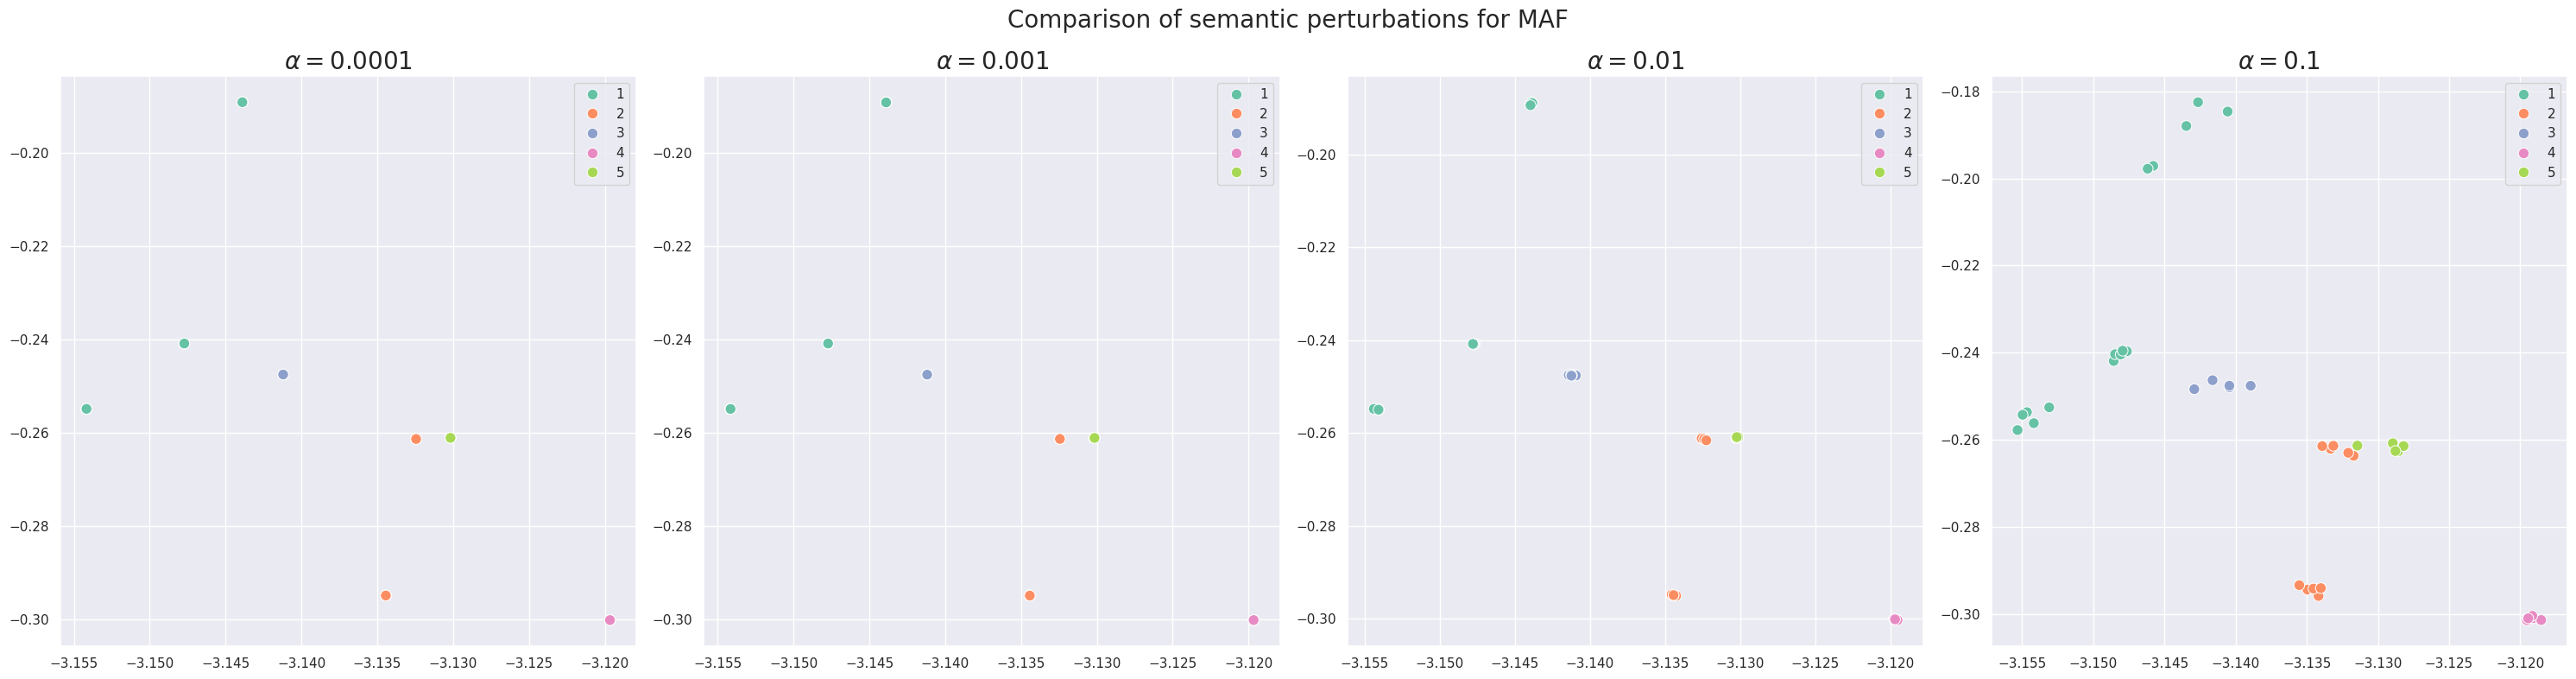

In [118]:
fig, ax = plt.subplots(1, len(ALPHAS), figsize=(30, 8))

for i in range(len(results_maf)):
    f_x, f_y, f_z = results_maf[i]
    alpha = ALPHAS[i]
    
    pca = get_pca(torch.cat([f_x, f_z], dim=0), 2)
    
    f_pca, r_pca = pca[:len(f_x)], pca[len(f_x):]
    
    sns.scatterplot(x=f_pca[:, 0], y=f_pca[:, 1], hue=f_y, palette='Set2', ax=ax[i], s=80)
    
    ax[i].set_title(rf'$\alpha={alpha}$', fontdict={'fontsize': 20})
    
fig.suptitle('Comparison of semantic perturbations for MAF', size=20)
fig.tight_layout()
plt.savefig('plots/maf_latent.png')
plt.show()

In [90]:
results_nice = []
for alpha in ALPHAS:
    print(alpha)
    maf_xs, maf_ys, z = perturbate(nice_flow, real_xs, y, alpha, 5)
    results_nice.append((maf_xs, maf_ys, z))

0.0001
0.001
0.01
0.1


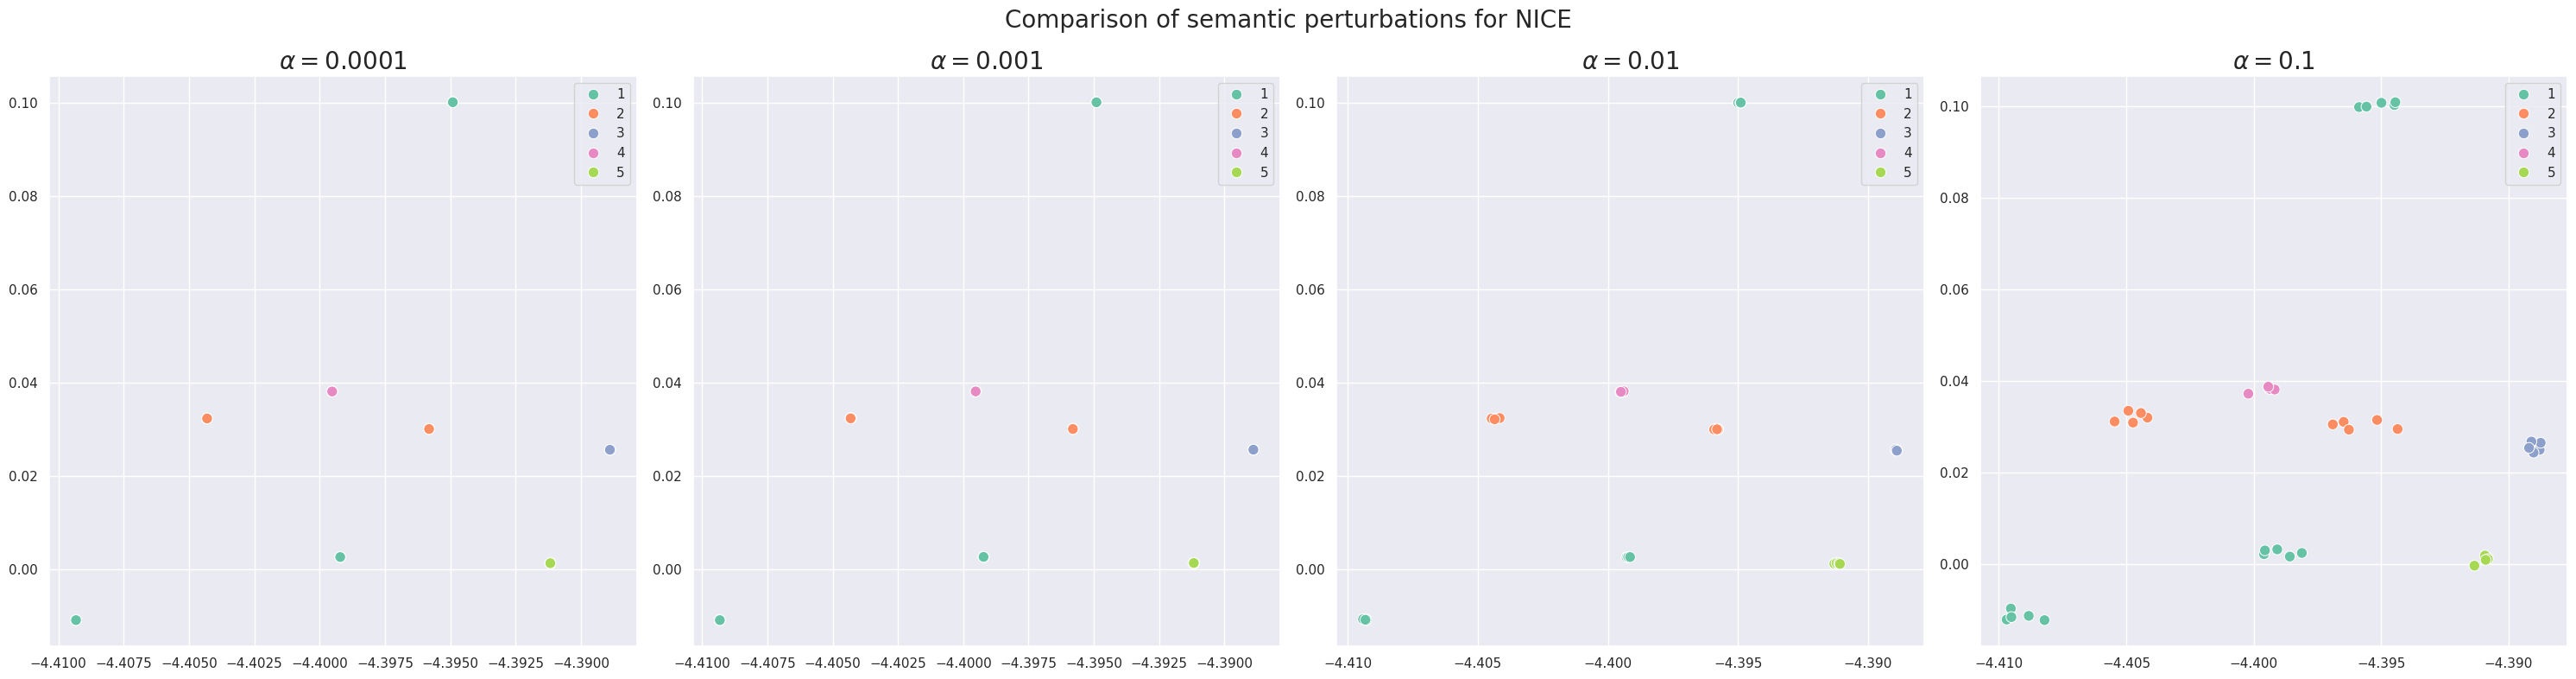

In [119]:
fig, ax = plt.subplots(1, len(ALPHAS), figsize=(30, 8))

for i in range(len(results_nice)):
    f_x, f_y, f_z = results_nice[i]
    alpha = ALPHAS[i]
    
    pca = get_pca(torch.cat([f_x, f_z], dim=0), 2)
    
    f_pca, r_pca = pca[:len(f_x)], pca[len(f_x):]
    
    sns.scatterplot(x=f_pca[:, 0], y=f_pca[:, 1], hue=f_y, palette='Set2', ax=ax[i], s=80)
    
    ax[i].set_title(rf'$\alpha={alpha}$', fontdict={'fontsize': 20})
    
fig.suptitle('Comparison of semantic perturbations for NICE', size=20)
fig.tight_layout()
plt.savefig('plots/nice_latent.png')
plt.show()

In [92]:
results_rnvp = []
for alpha in ALPHAS:
    print(alpha)
    maf_xs, maf_ys, z = perturbate(rnvp_flow, real_xs, y, alpha, 5)
    results_rnvp.append((maf_xs, maf_ys, z))

0.0001
0.001
0.01
0.1


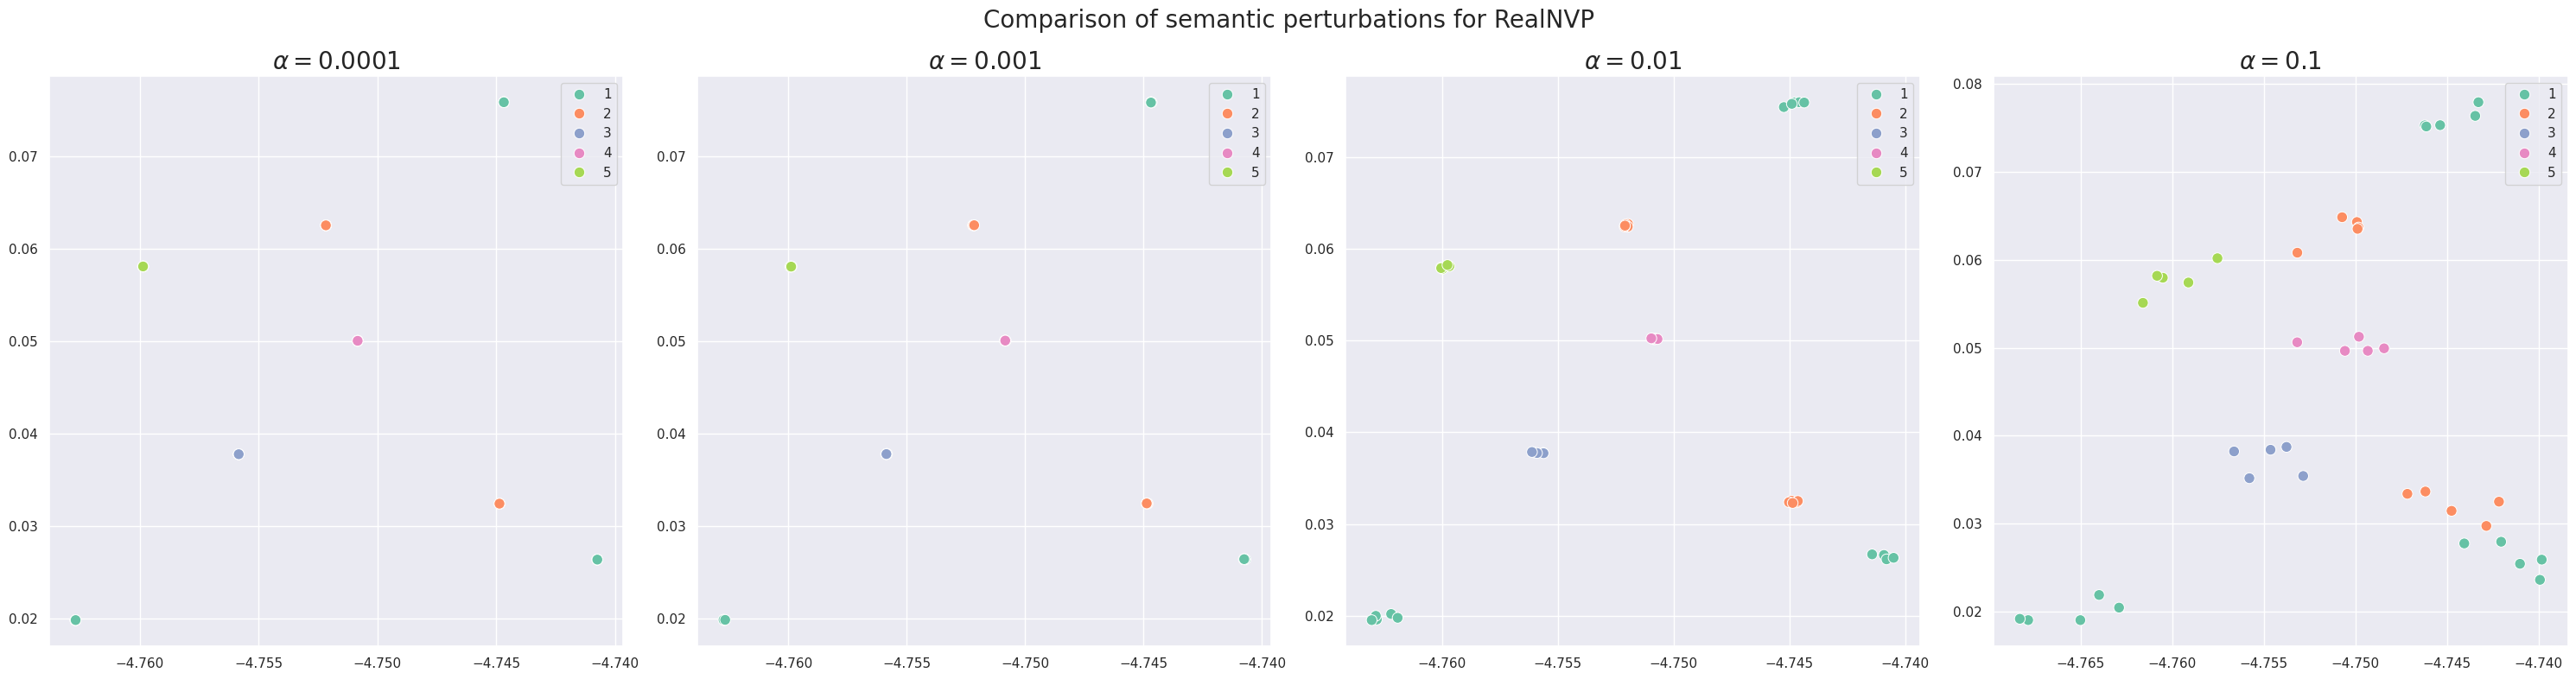

In [120]:
fig, ax = plt.subplots(1, len(ALPHAS), figsize=(30, 8))

for i in range(len(results_rnvp)):
    f_x, f_y, f_z = results_rnvp[i]
    alpha = ALPHAS[i]
    
    pca = get_pca(torch.cat([f_x, f_z], dim=0), 2)
    
    f_pca, r_pca = pca[:len(f_x)], pca[len(f_x):]
    
    sns.scatterplot(x=f_pca[:, 0], y=f_pca[:, 1], hue=f_y, palette='Set2', ax=ax[i], s=80)
    
    ax[i].set_title(rf'$\alpha={alpha}$', fontdict={'fontsize': 20})
    
fig.suptitle('Comparison of semantic perturbations for RealNVP', size=20)
fig.tight_layout()
plt.savefig('plots/rnvp_latent.png')
plt.show()